In [2]:
import numpy as np 
import pandas as pd

base_path = "/Users/kennethzhang/Desktop/VolAuction/data"

In [6]:
es_futures = pd.read_csv(base_path + "/es_futures_1m_all.csv")
es_futures['Datetime'] = pd.to_datetime(es_futures["Datetime"])
es_futures = es_futures.set_index('Datetime').sort_index()
es_futures.head(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,date
Datetime,,,,,,,,
2025-03-24 00:00:00-04:00,5754.0,5754.00,5752.75,5753.00,0,0.0,0.0,2025-03-24
2025-03-24 00:01:00-04:00,5753.0,5753.00,5752.75,5752.75,75,0.0,0.0,2025-03-24
2025-03-24 00:02:00-04:00,5753.0,5753.25,5752.75,5753.25,18,0.0,0.0,2025-03-24
2025-03-24 00:03:00-04:00,5753.0,5753.00,5752.50,5752.50,85,0.0,0.0,2025-03-24
2025-03-24 00:04:00-04:00,5752.5,5753.25,5752.50,5753.00,62,0.0,0.0,2025-03-24


In [7]:
es_futures['time'] = es_futures.index.time
es_futures['date'] = es_futures.index.date

In [17]:
close_df['date'] = close_df.index.date
open_df['date'] = open_df.index.date

close_df = close_df[['Close', 'date']].rename(columns={'Close': 'close'})
open_df = open_df[['Close', 'date']].rename(columns={'Close': 'open'})

/var/folders/bc/0sv4l9h92yb5pz7_7vm4gh900000gn/T/ipykernel_54181/1914564937.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  close_df['date'] = close_df.index.date
/var/folders/bc/0sv4l9h92yb5pz7_7vm4gh900000gn/T/ipykernel_54181/1914564937.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  open_df['date'] = open_df.index.date


In [18]:
merged = pd.merge(close_df, open_df, on='date', how='inner')
merged = merged.shift(-1).dropna()
merged['overnight_return'] = np.log(merged['open'] / merged['close'])

In [23]:
merged

,close,date,open,overnight_return
0,5828.50,2025-03-25,5828.25,-0.000043
1,5759.00,2025-03-26,5826.00,0.011567
2,5744.75,2025-03-27,5744.00,-0.000131
3,5622.25,2025-03-28,5722.75,0.017718
4,5643.75,2025-03-31,5566.75,-0.013737


In [20]:
log_returns = merged['overnight_return']

In [21]:
threshold = 3
mu = log_returns.mean()
sigma = log_returns.std()
jumps = log_returns[np.abs(log_returns - mu) > threshold * sigma]
lambda_ = len(jumps) / len(log_returns)
jump_mean = jumps.mean() if len(jumps) > 0 else 0
jump_std = jumps.std() if len(jumps) > 0 else 0.0001

In [ ]:
S0 = es_futures.iloc[-1]['Close']
T = 1 / 6.5  
dt = 1 / 390
n_paths = 1000
N = int(T / dt)
paths = np.zeros((n_paths, N))
paths[:, 0] = S0

for i in range(n_paths):
    for t in range(1, N):
        dW = np.random.normal(0, np.sqrt(dt))
        dN = np.random.poisson(lambda_ * dt)
        J = np.random.normal(jump_mean, jump_std) if dN else 0
        paths[i, t] = paths[i, t - 1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * dW + J)

log_returns_paths = np.log(paths[:, 1:] / paths[:, :-1])
path_vols = np.std(log_returns_paths, axis=1) * np.sqrt(390)
mean_vol = np.mean(path_vols)
std_vol = np.std(path_vols)

print("Forecasted Open-to-Close Realized Volatility (mean):", mean_vol)
print("Std of Vol Forecast (across paths):", std_vol)

Forecasted Open-to-Close Realized Volatility (mean): 0.01198918940732792
Std of Vol Forecast (across paths): 0.001164241716701537


% of Actual Path Within 5-95% Sim Band: 0.00%
Z-score of Realized Vol: -0.22


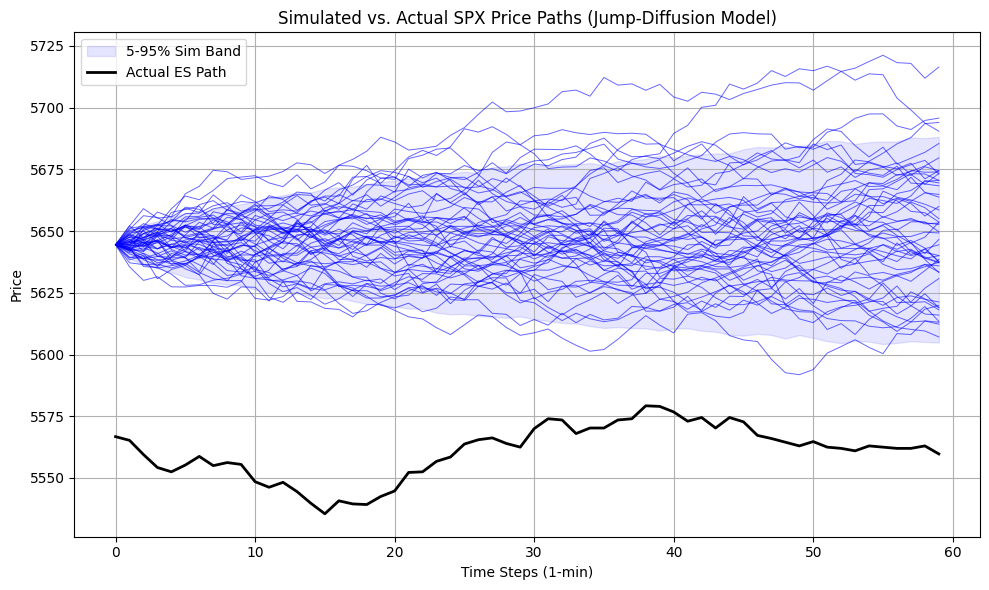

In [28]:
plt.figure(figsize=(10, 6))
for i in range(50):
    plt.plot(paths[i], linewidth=0.7, alpha=0.6, color='blue')

lower_band = np.percentile(paths, 5, axis=0)
upper_band = np.percentile(paths, 95, axis=0)
plt.fill_between(range(N), lower_band, upper_band, color='blue', alpha=0.1, label='5-95% Sim Band')

latest_date = es_futures['date'].max()
es_intraday = es_futures[(es_futures['date'] == latest_date) & (es_futures['time'] >= pd.to_datetime("09:30:00").time())]
es_prices = es_intraday['Close'].values[:N] 
if len(es_prices) == N:
    plt.plot(es_prices, linewidth=2, color='black', label='Actual ES Path')

    within_band = ((es_prices >= lower_band) & (es_prices <= upper_band)).mean()
    print(f"% of Actual Path Within 5-95% Sim Band: {within_band:.2%}")

    realized_vol = np.std(np.log(es_prices[1:] / es_prices[:-1])) * np.sqrt(390)
    z_score = (realized_vol - mean_vol) / std_vol
    print(f"Z-score of Realized Vol: {z_score:.2f}")

plt.title("Simulated vs. Actual SPX Price Paths (Jump-Diffusion Model)")
plt.xlabel("Time Steps (1-min)")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()